# Одномерная минимизация криловлинейной psf.
* поиск дальней точки через кепстр
* начальное приближение - полный перебор на срединном перпендикуляре
* уточнение одним из (стандартных) алгоритмов
<img src="pic/minimization_ill.png">

Время работы: 2:24

In [1]:
import numpy as np
from skimage import color, data, restoration, img_as_float, io
from skimage.restoration import richardson_lucy
from skimage.measure import compare_psnr

from scipy.signal import convolve2d
from scipy.optimize import minimize

from functools import partial
from tqdm import tqdm_notebook

from util import *
from richardson_lucy import *

In [2]:
prefix = "pic/one-dim-drawn-lena"

In [3]:
original = img_as_float(color.rgb2gray(io.imread('Lenna.png')))
#img_as_float(io.imread('original.png'))
iterations = 30

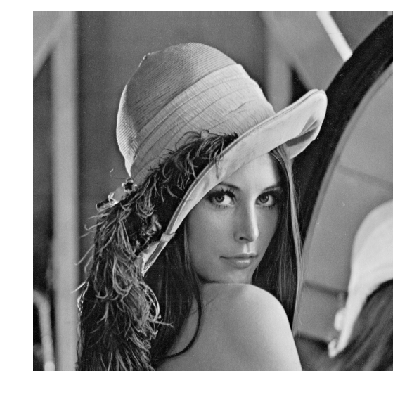

In [4]:
show_and_save_image(original, fname='{0}-original.png'.format(prefix))

In [5]:
original.dtype

dtype('float64')

In [6]:
psf_drawn = img_as_float(io.imread("input/drawn-psf2.bmp"))
if len(psf_drawn.shape) == 3:
    psf_drawn = psf_drawn[:,:,0]
psf_drawn /= np.sum(psf_drawn)

In [7]:
lifting_drawn_blurred = convolve2d(original, psf_drawn, 'same', 'symm')
lifting_drawn_blurred = edgetaper(lifting_drawn_blurred, gkern2(60, 11))

deconv_orig = richardson_lucy_matlab(lifting_drawn_blurred, psf_drawn,
                                     iterations=iterations)#dampar=s_n, 
psnr_orig = compare_psnr_crop(original, deconv_orig['image'])

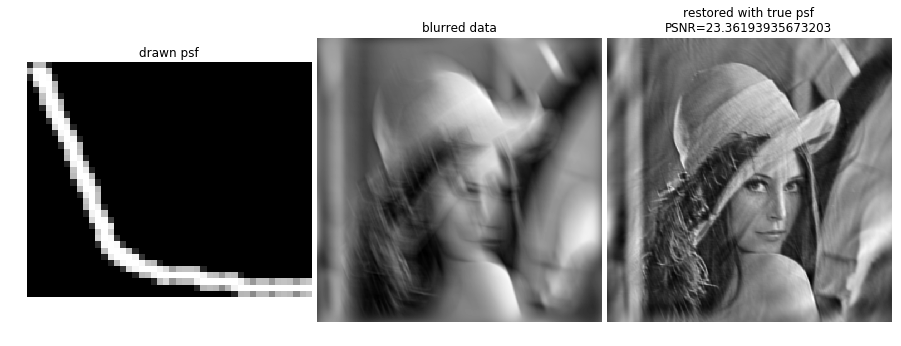

In [8]:
show_results(psf_drawn, lifting_drawn_blurred, deconv_orig['image'],
            titles=['drawn psf', 'blurred data', 'restored with true psf\nPSNR={0}'.format(psnr_orig)])

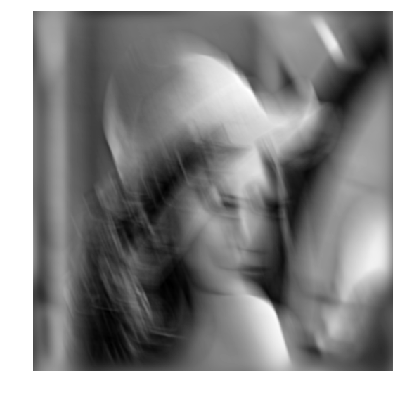

In [9]:
show_and_save_image(lifting_drawn_blurred, fname='{0}-blurred.png'.format(prefix))

In [10]:
psf_drawn.shape

(38, 46)

In [11]:
s_n, S_find = find_noise(lifting_drawn_blurred)
s_n

8.342285999286944e-05

In [12]:
N,M = lifting_drawn_blurred.shape
# ( ifft2 (100* log (1+ abs ( fft2 ( I ) ) ) ) ) ;
K = np.fft.ifftn(100*np.log(1+np.abs(np.fft.fftn(lifting_drawn_blurred))))
K_shift = np.fft.fftshift(K)

n, m, = K_shift.shape

#masksize = 10
K_shift[:, m//2] = 1
K_shift[n//2, :] = 1
#K_shift[n//2-masksize:n//2+masksize+1, m//2-masksize:m//2+masksize+1] = 1
mask_sigma = 2 # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
XX, YY = np.meshgrid(range(m), range(n))
#gauss_mask = 1/(mask_sigma*2*np.sqrt(pi))*np.exp(-((XX-m//2)**2 + (YY-n//2)**2) / (2*mask_sigma**2))
gauss_mask = np.exp(-((XX-m//2)**2 + (YY-n//2)**2) / (2*mask_sigma**2))
K_shift -= K_shift*gauss_mask

r,c = np.unravel_index(np.argmin(np.real(K_shift), axis=None), K_shift.shape)
print(c,r)
x0_2 = np.array([c - m//2, r - n//2])

if x0_2[0]<0:
    x0_2 = -x0_2
x0_1 = x0_2/2# + np.array([4,-4])
x0 = np.concatenate((x0_1, x0_2))
print(x0)

211 220
[22.5 18.  45.  36. ]


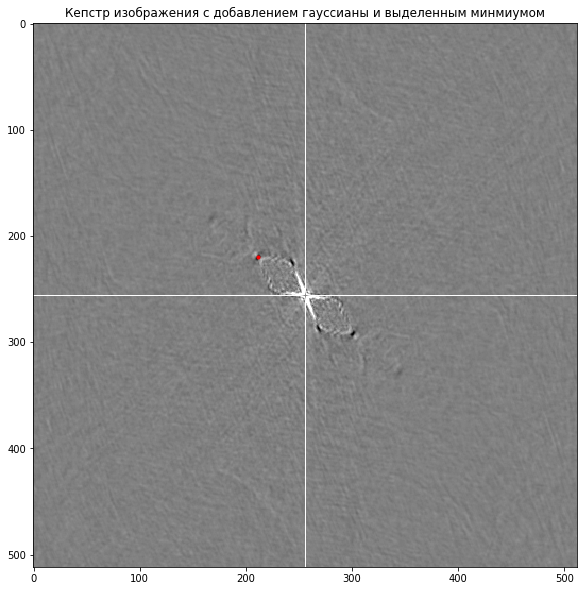

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(np.real(K_shift), -1, 1), 'gray')#, vmin=noisy.min(), vmax=noisy.max())
#plt.plot(n//2 + x0_2[1], m//2 + x0_2[0], 'r.')
plt.plot(c, r, 'r.')
plt.title('Кепстр изображения с добавлением гауссианы и выделенным минмиумом')
plt.show()

In [14]:
K_shift[c,r]

(-0.05276883175571755+6.694146920580409e-15j)

In [15]:
x1_vec = np.array([x0_2[1], -x0_2[0]])
x1_vec = x1_vec / vec_len(x1_vec)
print(x1_vec)

[ 0.62469505 -0.78086881]


In [16]:
cost_fun = partial(funcToMinimizeCurvedNormal, xy2=x0_2, I_blurred=lifting_drawn_blurred,
                   iterations=iterations, eps=1e-5, dampar=s_n)

In [17]:
L = vec_len(x0_2)

In [18]:
distances = np.linspace(-L/2, L/2, 30)
best_val = 1e9 #+inf
best_dist = 0
for dist in distances:
    val = cost_fun(dist)
    if val < best_val:
        best_dist = dist
        best_val = val

In [19]:
best_dist, best_val

(-28.81405906844782, 4.331016916790528e-05)

In [20]:
point2 = second_point(x0_2, best_dist)
points_found = np.concatenate((point2, x0_2))
print(points_found)

[ 4.5 40.5 45.  36. ]


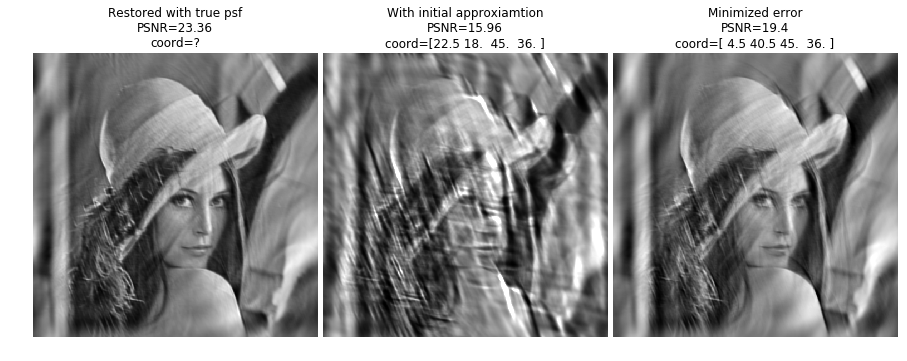

In [21]:
deconv_orig = richardson_lucy_matlab(lifting_drawn_blurred, psf_drawn, iterations=iterations, 
                                     dampar=s_n)
psnr_orig = compare_psnr_crop(original, deconv_orig['image'])

psf_init = bezier_psf2(x0)
deconv_init = richardson_lucy_matlab(lifting_drawn_blurred, psf_init, iterations=iterations, 
                                     dampar=s_n)
psnr_init = compare_psnr_crop(original, deconv_init['image'])

#points_found = res_my_grad2['x']
psf_found = bezier_psf2(points_found)
deconv_found = richardson_lucy_matlab(lifting_drawn_blurred, psf_found, iterations=iterations, 
                                      dampar=s_n)
psnr_found = compare_psnr_crop(original, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord=?'.format(psnr_orig.round(2)), 
                     'With initial approxiamtion\nPSNR={0}\ncoord={1}'.format(psnr_init.round(2), x0.round(4)),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(2), points_found.round(4))],
             savefig='{0}.png'.format(prefix))

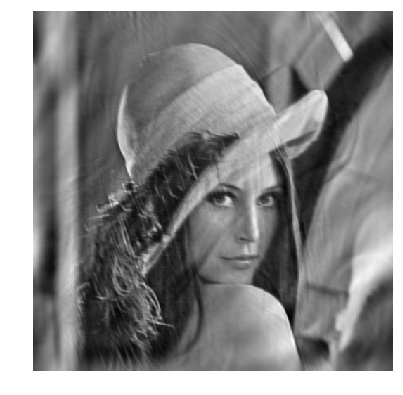

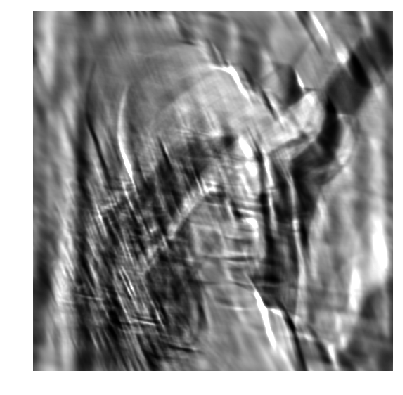

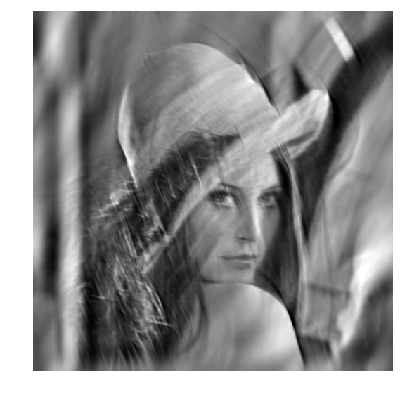

In [22]:
for image, title in [[deconv_orig['image'], '{0}-restored-true-psf.png'.format(prefix)],
                     [deconv_init['image'], '{0}-restored-initial-approx.png'.format(prefix)],
                     [deconv_found['image'], '{0}-restored-second-approx.png'.format(prefix)]]:
    show_and_save_image(image, fname=title)

In [23]:
x1_1 = point2
x1_2 = x0_2
for it in range(10):
    changed = False
    # move third point
    cost_fun1 = partial(funcToMinimizeCurved3, xy1=x1_1, I_blurred=lifting_drawn_blurred, 
                        iterations=iterations, eps=1e-5, dampar=s_n)
    res1 = minimize_grad(cost_fun1, x0=x1_2, alpha=1000, maxiter=5)
    if not (x1_2 == res1.x).all():
        changed = True
    x1_2 = res1.x
    print(x1_1, x1_2)
    cost_fun2 = partial(funcToMinimizeCurved2, xy2=x1_2, I_blurred=lifting_drawn_blurred, 
                        iterations=iterations, eps=1e-5, dampar=s_n)
    res2 = minimize_grad(cost_fun2, x0=x1_1, alpha=1000, maxiter=5)
    if not (x1_1 == res2.x).all():
        changed = True
    x1_1 = res2.x
    print(x1_1, x1_2)
    if not changed:
        break

[ 4.5 40.5] [45 36]
[ 4.5 40.5] [45 36]


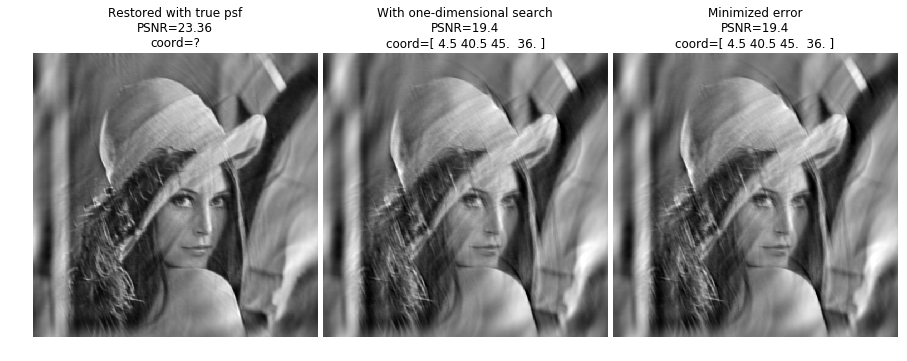

In [24]:
deconv_orig = richardson_lucy_matlab(lifting_drawn_blurred, psf_drawn, iterations=iterations, 
                                     dampar=s_n)
psnr_orig = compare_psnr_crop(original, deconv_orig['image'])

psf_init = bezier_psf2(points_found)
deconv_init = richardson_lucy_matlab(lifting_drawn_blurred, psf_init, iterations=iterations, 
                                     dampar=s_n)
psnr_init = compare_psnr_crop(original, deconv_init['image'])

#points_found = res_my_grad2['x']
#points_found2 = res_nelder.x
points_found2 = np.concatenate((x1_1, x1_2))
psf_found = bezier_psf2(points_found2)
deconv_found = richardson_lucy_matlab(lifting_drawn_blurred, psf_found, iterations=iterations, 
                                      dampar=s_n)
psnr_found = compare_psnr_crop(original, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord=?'.format(psnr_orig.round(2)), 
                     'With one-dimensional search\nPSNR={0}\ncoord={1}'.format(psnr_init.round(2), points_found.round(4)),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(2), points_found2.round(4))],
             savefig='{0}-thiner.png'.format(prefix))

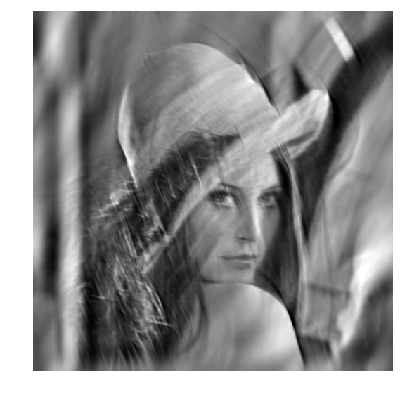

In [25]:
for image, title in [[deconv_found['image'], '{0}-restored-final.png'.format(prefix)]]:
    show_and_save_image(image, fname=title)

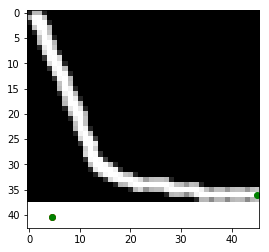

In [26]:
plt.imshow(psf_drawn)
plt.plot(points_found2[0], points_found2[1], 'ro')
plt.plot(points_found[0], points_found[1], 'go')
plt.plot(points_found[2], points_found[3], 'go')
plt.show()

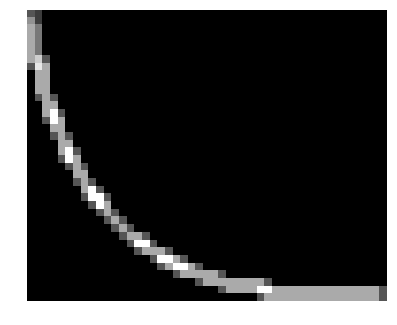

In [27]:
show_and_save_image(psf_found, fname='{0}-found-psf.png'.format(prefix))